This notebook is for demonstrating how to use a trained PM2.5 prediction model to make predictions on a target area.
There is also a script version for just generating predictions in `scripts/predict.py`. Both utilize the same underlying prediction logic.

The input is a CSV/Dataframe of target locations, represented by coordinates. The file should have the ff. three columns: `id`, `longitude`, and `latitude`

In our sample notebook, our goal is to predict daily PM2.5 levels for the Mueang Chiang Mai admin level 2 district for the year 2021.

To visualize this input (each coordinate is a row in the CSV file):

![Mueang Chiang Mai Tile Centroids](img/chiangmai_centroids.png)

(*This was generated with QGIS and exported to a CSV file. The points are centroids of 1km x 1km tiles across the whole distrtict.*)



# Pre-requisites

## Downloading the necessary files

We need some data/model files to run this notebook. The most convenient way is to download this [Gdrive folder](https://drive.google.com/drive/u/0/folders/1Ni-OWGovH-4gV2VhJeao0jABMW_Wp2k_) and place it in your local `data` folder in the project root. That is, this `data` folder on GDrive should correspond to your local `data/` folder.

If you don't want to download all those files however, you can also manually download the ff. and place them in your local `data/` folder:
- `mueang_chiang_mai_tile_centroids.csv`
- `final_openaq_model.pkl`
- `tha_general_20202.tif`
- `predictions_chiangmai_2021.csv` *(in case you want to skip running the model and just want to run the EDA cells on the 2021 chiang mai predictions)*


*Note: Depending on your internet connection and on how many days you're predicting for, the run can take a while because it needs to download the datasets from GEE and collect the necessary features.*

## Sign-up for a GEE account

The feature collection functions utilize the GEE API to collect data. As such, you will be prompted to log-in when you run the predict function. Sign-up for an account if you haven't yet: https://signup.earthengine.google.com/ 

# Imports

In [1]:
%load_ext autoreload 
%autoreload 2

import geopandas as gpd

import branca
import folium
import pandas as pd
from shapely import wkt

import sys
sys.path.append("../../")

from src.config import settings
from src.data_processing import  geom_utils
from src.prediction import predict_utils

# Parameters

In [2]:
# If True, prediction will be run on just a small subset of locations
DEBUG = False

# Desired date range
START_DATE = "2021-01-01"
END_DATE = "2021-01-31"

# CSV file for target roll-out location
CENTROIDS_PATH = settings.DATA_DIR / "mueang_chiang_mai_tile_centroids.csv"

# Where to save the model predictions of  daily PM2.5 levels
OUTPUT_PREDICTIONS_FILE = settings.DATA_DIR / "chiangmai_january_2021_predictions.csv" if not DEBUG else "data/debug.csv"

# Path to the model to be used for prediction
MODEL_PATH = settings.DATA_DIR / "latest_model.pkl"

# Path to the population raster (In our study, we're using the Thai 2020 HRSL raster)
HRSL_TIF = settings.DATA_DIR / "tha_general_2020.tif"

# ID Column in the target CSV file
ID_COL = "id"

# What to name the column for predictions
PRED_COL = "predicted_pm2.5"

# Model being used was trained using 1km x 1km bounding box
BBOX_SIZE_KM = 1

# Load Area of Interest

In [6]:
locations_df = pd.read_csv(CENTROIDS_PATH)
locations_df.head()

,id,longitude,latitude
0,27,98.87065,18.833303
1,28,98.87065,18.824801
2,29,98.87065,18.816298
3,30,98.87065,18.807794
4,31,98.87065,18.799291


# Predict



In [ ]:
results_df = predict_utils.predict(
        locations_df,
        start_date=START_DATE,
        end_date=END_DATE,
        hrsl_tif=HRSL_TIF,
        model_path=MODEL_PATH,
        bbox_size_km=BBOX_SIZE_KM,
        id_col=ID_COL,
        pred_col=PRED_COL,
    )

In [10]:
results_df.to_csv(OUTPUT_PREDICTIONS_FILE, index=False)

In [13]:
results_df.columns

Index(['date', 'id', 'longitude', 'latitude', 'total_population', 'AAI_mean',
       'AAI_min', 'AAI_max', 'AAI_median', 'CAMS_AOD_055_mean',
       'CAMS_AOD_055_min', 'CAMS_AOD_055_max', 'CAMS_AOD_055_median',
       'NDVI_mean', 'NDVI_min', 'NDVI_max', 'NDVI_median', 'EVI_mean',
       'EVI_min', 'EVI_max', 'EVI_median', 'dewpoint_temperature_2m_mean',
       'dewpoint_temperature_2m_min', 'dewpoint_temperature_2m_median',
       'dewpoint_temperature_2m_max', 'temperature_2m_mean',
       'temperature_2m_min', 'temperature_2m_median', 'temperature_2m_max',
       'u_component_of_wind_10m_mean', 'u_component_of_wind_10m_min',
       'u_component_of_wind_10m_median', 'u_component_of_wind_10m_max',
       'v_component_of_wind_10m_mean', 'v_component_of_wind_10m_min',
       'v_component_of_wind_10m_median', 'v_component_of_wind_10m_max',
       'surface_pressure_mean', 'surface_pressure_min',
       'surface_pressure_median', 'surface_pressure_max',
       'total_precipitation_daily',

# EDA on Predictions

## Utility Functions

In [4]:
def load_results(results_path, pred_col=PRED_COL):
    df = pd.read_csv(results_path)
    # Post-processing: clip negative values to 0
    df[pred_col] = df[pred_col].apply(lambda x: x if x > 0 else 0)
    return df

In [5]:
def aggregate_preds(results_path, start_date=None, end_date=None, id_col=ID_COL, pred_col=PRED_COL):
    # Initialize DF
    df = load_results(results_path)
    if start_date and end_date:
        # Filter according to dates
        date_mask =(df['date'] >= start_date) & (df['date'] <= end_date)
        df = df[date_mask]
        
    # Initialize GDF
    df = geom_utils.generate_bboxes(df, bbox_size_km=BBOX_SIZE_KM, geometry_col="geometry")
    gdf = gpd.GeoDataFrame(df, geometry=df["geometry"].apply(lambda x: wkt.loads(x)))
    
    # Get the average predicted value per tile
    gdf = gdf.dissolve(by=[ID_COL], aggfunc='mean')
    
    return gdf
    

In [6]:
def categorize_value(value):
    if value >= 250.5:
        return "hazardous"
    if value >= 150.5:
        return "very_unhealthy"
    if value >= 55.5:
        return "unhealthy"
    if value >= 35.5:
        return "unhealthy_for_sensitive_groups"
    if value >= 12.1:
        return "moderate"
    return "good"

def generate_pm25_cmap(min=0, max=500.0):
    lower_bounds = [0.0, 12.1, 35.5, 55.5, 150.5, 250.5]
    colors = ["green", "yellow", "orange", "red", "purple", "brown"]
    step = branca.colormap.StepColormap(colors,
                       vmin=min, vmax=max, index=lower_bounds,
                       caption='Predicted PM2.5 Levels')
    return step


In [7]:
def viz_preds(gdf, tooltip=True, pred_col=PRED_COL):    
    gdf_centroid = gdf.dissolve().geometry.centroid.values[0]
    
    # Categorize for the tooltip
    gdf["category"] = gdf[pred_col].apply(lambda x: categorize_value(x))
    
    m = folium.Map(location=[gdf_centroid.y, gdf_centroid.x], width=800, height=800, zoom_start=12)
    style_kwds = {
        "opacity": 0.3
    }
    
    gdf.explore(pred_col, m=m, style_kwds=style_kwds, tooltip=tooltip, cmap=generate_pm25_cmap())
    return m
    

## Results File to perform EDA on

In [8]:
results_path = settings.DATA_DIR/"predictions_chiangmai_2021.csv"

## Annual PM2.5 Mean

In [9]:
df = load_results(results_path)
df[PRED_COL].mean()

33.14694928831249

## PM2.5 Levels per Month

In [10]:
df = load_results(results_path)
df["month"] = pd.to_datetime(df["date"]).dt.month
df["year"] = pd.to_datetime(df["date"]).dt.year
summary = df[["month", "year", PRED_COL]].groupby(["month", "year"]).describe()
summary.columns = summary.columns.droplevel()

summary

,,count,mean,std,min,25%,50%,75%,max
month,year,,,,,,,,
1,2021,6386.0,63.341345,19.154061,9.560035,49.839914,64.013845,75.491304,128.008870
2,2021,5768.0,62.712000,20.386008,0.000000,50.420704,62.218142,75.830187,154.845050
3,2021,6386.0,89.400631,29.061196,12.208568,70.603714,82.384683,106.431964,194.495180
4,2021,6180.0,39.368582,23.987580,0.000000,23.908068,33.161674,46.084322,125.215570
5,2021,6386.0,20.232414,7.557263,0.000000,14.861941,20.420446,25.167452,47.917957
6,2021,6180.0,12.384718,5.910474,0.000000,8.034402,11.689604,15.377459,41.782063
7,2021,6386.0,9.755273,3.372766,0.000000,7.362451,9.453353,11.803314,21.478884
8,2021,6386.0,11.460670,4.219821,0.000000,8.422496,10.834995,13.911296,29.069271
9,2021,6180.0,12.319562,4.575653,0.000000,8.674928,12.057009,15.487342,30.527950


<AxesSubplot:xlabel='month'>

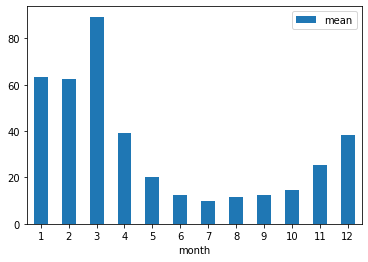

In [11]:
summary.reset_index().plot.bar(x="month", y="mean", rot=0)

Agricultural burning season in Thailand varies from place to place, but is generally in the earlier parts of the year.

This [article by iqair](https://www.iqair.com/blog/air-quality/thailand-2021-burning-season) conducted an analysis and considered Jan-March as the general burning season. Our model's predictions for Chiang Mai seem to conform to this.

Furthermore, the trend seems to be consistent with the monthly mean PM2.5 levels reported by IQAir where the start of the year sees the highest levels of PM2.5, which lowers starting May, then increases again towards the end of the year.

![Image taken from: https://www.iqair.com/blog/air-quality/thailand-2021-burning-season](img/chiangmai_monthly_averages_iqair.png)

## Visualize Certain Months

In [12]:
keep_cols = [ID_COL, PRED_COL, "category"]

In [13]:
# March
gdf = aggregate_preds(results_path, 
                      start_date="2021-03-01", 
                      end_date="2021-03-31")
viz_preds(gdf, tooltip=keep_cols)

In [14]:
# June
gdf = aggregate_preds(results_path, 
                      start_date="2021-06-01", 
                      end_date="2021-06-30")
viz_preds(gdf, tooltip=keep_cols)